# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            #.config('spark.master', "local")
            .config('spark.master', "local[20]")
            #.config('spark.master', "local[24]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Test new dipper algorithms

In [79]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('dipper_data_challenge')

In [10]:
def parse_row(row):
    mjds = (row['mjd_g'], row['mjd_r'], row['mjd_i'])
    mags = (row['mag_g'], row['mag_r'], row['mag_i'])
    magerrs = (row['magerr_g'], row['magerr_r'], row['magerr_i'])
    all_xpos = (row['xpos_g'], row['xpos_r'], row['xpos_i'])
    all_ypos = (row['ypos_g'], row['ypos_r'], row['ypos_i'])
    all_catflags = (row['catflags_g'], row['catflags_r'], row['catflags_i'])
    
    valid_mjds = []
    valid_mags = []
    valid_magerrs = []
    for args in zip(mjds, mags, magerrs, all_xpos, all_ypos, all_catflags):
        valid_mjd, valid_mag, valid_magerr = dipper.filter_ztf_observations(*args)
        valid_mjds.append(valid_mjd)
        valid_mags.append(valid_mag)
        valid_magerrs.append(valid_magerr)
        
    mjd, mag, magerr = dipper.parse_light_curve(mjds, mags, magerrs)
    
    return mjd, mag, magerr

RA+Dec: 72.596203+39.118038

Dip details:
integral   : 0.7730388045310974
integral_uncertainty: 0.14087148010730743
significance: 5.487546920776367
start_mjd  : 58469.5703125
center_mjd : 58474.1171875
end_mjd    : 58477.16015625
length     : 7.589622974395752
max_gap    : 3.9788658618927
max_gap_fraction: 0.5242508053779602
window_start_mjd: 58467.95703125
dip_observation_count: 9
significant_observation_count: 3
core_not_significant_fraction: 0.0
significant_width: 1.0026851892471313
ref_observation_count: 239
ref_pull_std: 1.1957701444625854
ref_large_pull_fraction: 0.025104602798819542


<IPython.core.display.Javascript object>


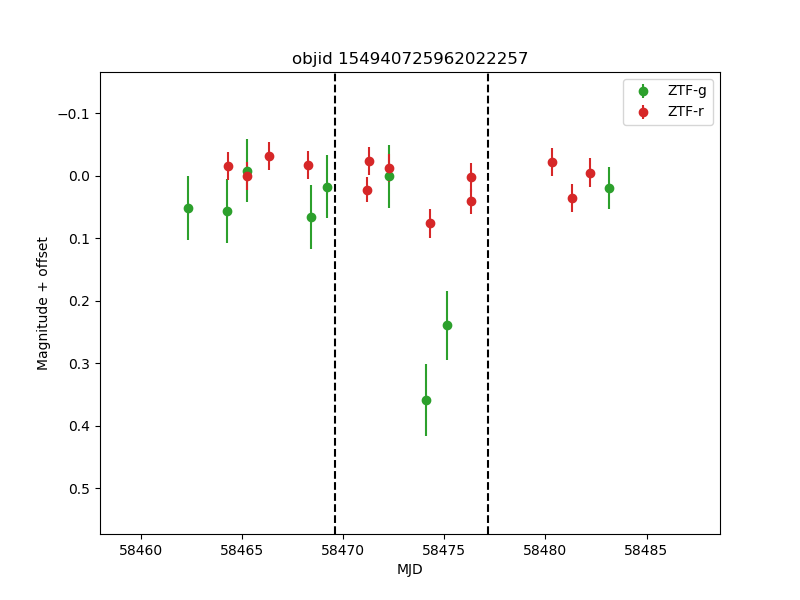

In [16]:
dipper.plot_light_curve(asdf[0])

In [12]:
mjd, mag, magerr = parse_row(asdf[0])

In [ ]:
asdf[0]a

# Find the best "dippers"

In [1395]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('wtf_full_oct19_6')

In [1470]:
import importlib
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [1398]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r'],
            wtf['mjd_i'],
            wtf['mag_i'],
            wtf['magerr_i'],
            wtf['xpos_i'],
            wtf['ypos_i'],
            wtf['catflags_i'],
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        # & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        #& (sparkfunc.col("dip.significant_width") >= 0.5)
        & (sparkfunc.col("dip.significance") >= 10)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
    )
)

In [1471]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    #.drop('dip')
    .select(
        '*',
    )
    .where(
        #(sparkfunc.col("dip.significant_observation_count") >= 3)
        #(sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        #(sparkfunc.col("dip.significant_width") >= 0.5)
        (sparkfunc.col("dip.significance") >= 20)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        #(sparkfunc.col("dip.max_gap_fraction") < 0.8)
    )
)

In [1472]:
aa = rescored_wtf.head(100)

In [1456]:
%matplotlib notebook

<IPython.core.display.Javascript object>


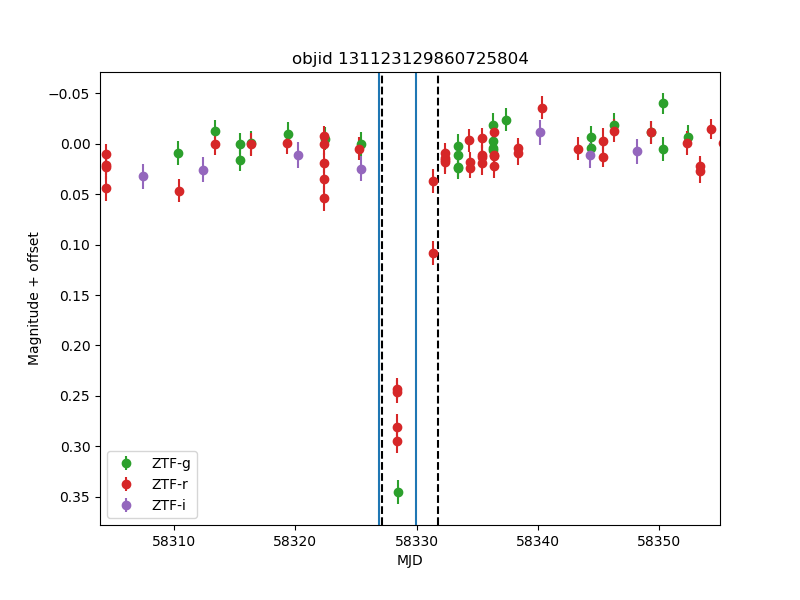

In [1476]:
idx = 0
dipper.plot_light_curve(aa[idx], parsed=True, verbose=False, zoom=True)
z = dipper.measure_dip_row(aa[idx])
plt.axvline(z['start_mjd'])
plt.axvline(z['end_mjd'])

In [1399]:
%%time

# Get the best dippers
print(f"Initial dataset: {wtf.count()} light curves.")
#best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).head(1000)
best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).collect()
print(f"Found {len(best_dippers)} dippers")

Initial dataset: 88092 light curves.
Found 0 dippers
CPU times: user 216 ms, sys: 167 ms, total: 384 ms
Wall time: 5min 1s


In [1403]:
%matplotlib inline

In [1409]:
# Plot a light curve
for i in range(10):
    dipper.plot_light_curve(best_dippers[i], verbose=False, zoom=True)
    #dipper.plot_dip(best_dippers[i])

IndexError: list index out of range

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


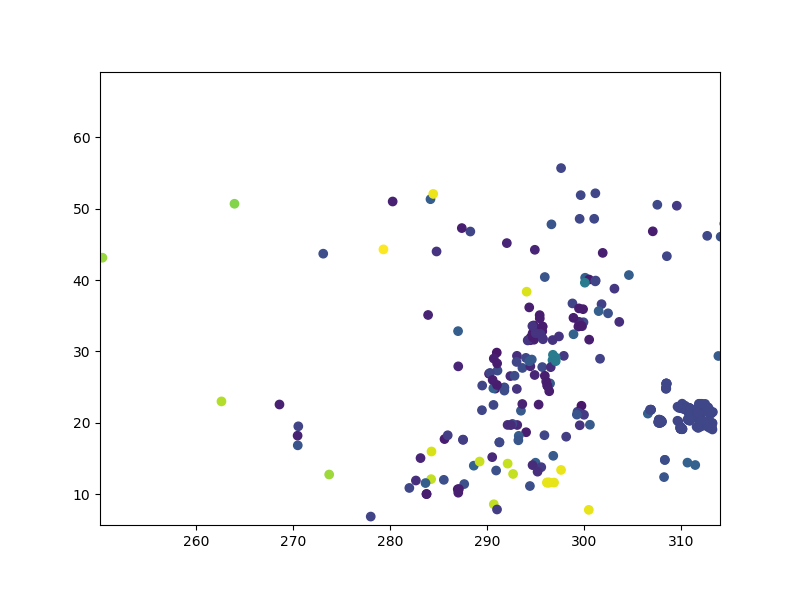

In [52]:
ra = np.array([i['ra'] for i in best_dippers])
dec = np.array([i['dec'] for i in best_dippers])
mjd = np.array([i['dip']['center_mjd'] for i in best_dippers])
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(ra, dec, c=mjd)

In [26]:
import pandas as pd
df = pd.DataFrame([i.asDict() for i in best_dippers])

In [25]:
best_dippers[0].asDict()

{'objid': 84772845093064935,
 'ra': 284.50932277976193,
 'dec': -19.354513106547607,
 'mean_mag_g': 14.871501445770264,
 'mean_mag_r': 14.696561066501111,
 'mean_mag_i': None,
 '_debug_first_ra': 284.5093165,
 '_debug_first_dec': -19.3545132,
 'ps1_gMeanPSFMag': 14.7668,
 'ps1_rMeanPSFMag': 14.6095,
 'ps1_iMeanPSFMag': 14.5762,
 'mjd_g': [58728.164317111106, 58757.14646991111],
 'mag_g': [15.032293319702148, 14.710709571838379],
 'magerr_g': [0.01608196459710598, 0.01580357551574707],
 'psfflux_g': [26467.806640625, 38720.765625],
 'psffluxerr_g': [489.9927978515625, 506.4166259765625],
 'catflags_g': [0, 0],
 'expid_g': [97416414, 100314629],
 'xpos_g': [691.52197265625, 707.5369873046875],
 'ypos_g': [1022.8200073242188, 1063.134033203125],
 'nobs_g': 2,
 'mjd_r': [58305.3548611,
  58694.235532411105,
  58665.302881911106,
  58703.21798611111,
  58718.244074111106,
  58694.23598381111,
  58665.30333331111,
  58703.21843751111,
  58718.245520811106,
  58694.287141211105,
  58665.32130

In [33]:
df['dip'][0]['center_mjd']

58725.31640625

In [55]:
np.sum(weird_mask)

340

In [53]:
weird_mask = (ra > 307) & (ra < 314) & (dec > 19) & (dec < 23)

<IPython.core.display.Javascript object>


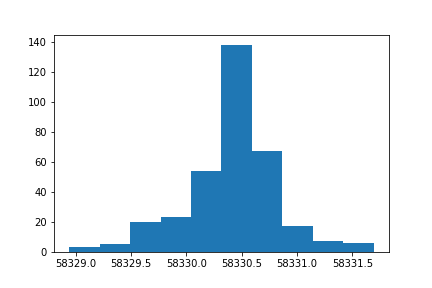

(array([  3.,   5.,  20.,  23.,  54., 138.,  67.,  17.,   7.,   6.]),
 array([58328.94140625, 58329.21640625, 58329.49140625, 58329.76640625,
        58330.04140625, 58330.31640625, 58330.59140625, 58330.86640625,
        58331.14140625, 58331.41640625, 58331.69140625]),
 <a list of 10 Patch objects>)

In [54]:
plt.figure()
plt.hist(mjd[weird_mask])

RA+Dec: 311.782921+21.533159

Dip details:
integral   : 0.6099096536636353
integral_uncertainty: 0.03722697123885155
significance: 16.383543014526367
start_mjd  : 58327.30078125
center_mjd : 58330.46875
end_mjd    : 58331.6875
length     : 4.38621711730957
max_gap    : 2.9334142208099365
max_gap_fraction: 0.6687799692153931
window_start_mjd: 58326.3359375
dip_observation_count: 4
significant_observation_count: 3
core_not_significant_fraction: 0.0
significant_width: 2.928657293319702
ref_observation_count: 361
ref_pull_std: 1.1433324813842773
ref_large_pull_fraction: 0.011080332100391388


<IPython.core.display.Javascript object>


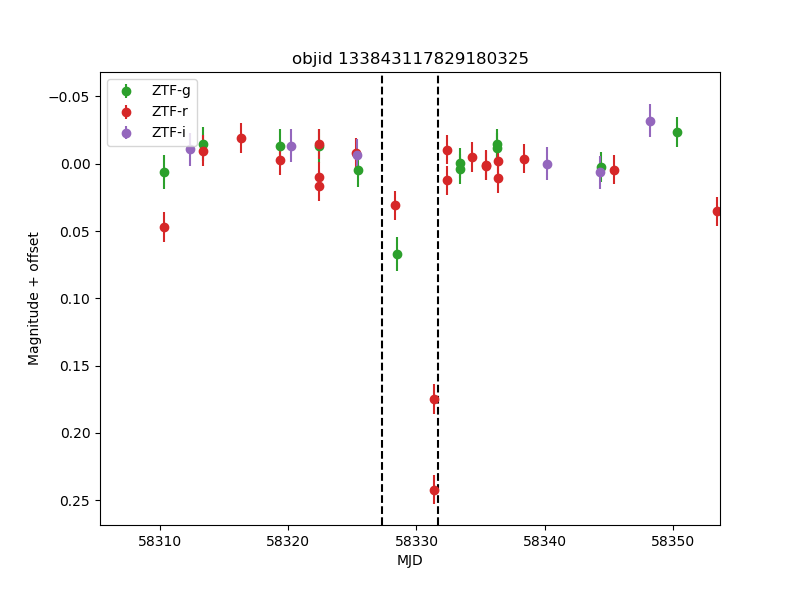

In [49]:
dipper.plot_light_curve(best_dippers[np.where(weird_mask)[0][6]], zoom=True)

In [ ]:
# Show an interactive display of the light curves
dipper.plot_interactive(best_dippers)

# Rerun over the full ZTF dataset

Warning! This takes a long time to run. With the latest dipper code, it is ~2000 core hours. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. It is also possible to run on AWS with hundreds or even thousands of cores.

In [5]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')
#ztf = catalog.load('wtf_full_oct19_6')

In [6]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    #.drop('dip')
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r'],
            ztf['mjd_i'],
            ztf['mag_i'],
            ztf['magerr_i'],
            ztf['xpos_i'],
            ztf['ypos_i'],
            ztf['catflags_i']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") >= 5)
    )
    .write.parquet('./query_wtf_60.parquet')
)

KeyboardInterrupt: 

In [ ]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('./query_wtf_60.parquet')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_60', repartition=True)

In [62]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('../../edata/ztf_boyajian/s3_test_wtf/')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_6', repartition=True)

# Tests of the dipper finder on simulations

In [17]:
def simulate_light_curve(N=1000, err=0.01, width=5, depth=0.2):
    x = np.sort(np.random.uniform(0, 1000, N))
    y = np.random.normal(size=N) * err
    yerr = np.ones(N) * err
    y += depth * np.exp(-(x-500)**2 / 2 / width**2)
    #y += depth * np.exp(-(x-525)**2 / 2 / width**2)
    
    return x, y, yerr

In [18]:
import importlib
import dipper
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [19]:
def measure_dip(x, y, yerr):
    bin_edges = np.hstack([0, (x[1:] + x[:-1]) / 2., 1000])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    wf = y * bin_widths
    ws2 = bin_widths**2 * yerr**2
    sig = y / yerr

    integral = np.zeros((len(x), len(x)))
    intvar = np.zeros((len(x), len(x)))
    numsig = np.zeros((len(x), len(x)), dtype=int)

    for i in range(len(x)):
        if i != 0:
            integral[i] = integral[i-1]
            intvar[i] = intvar[i-1]
            numsig[i] = numsig[i-1]

        integral[i, :i+1] += wf[i]
        intvar[i, :i+1] += ws2[i]
        if sig[i] >= 3:
            numsig[i, :i+1] += 1
            
    
    intvar[intvar == 0] = 1
    significance = integral / np.sqrt(intvar)
    end_idx, start_idx = np.unravel_index(np.argmax(significance), significance.shape)
    start = bin_edges[start_idx]
    end = bin_edges[end_idx+1]
    max_significance = significance[end_idx, start_idx]
    print(start, end, max_significance)
    
    mask = numsig < 3
    integral[mask] = 0
    intvar[mask] = 1
    #intvar[intvar == 0] = 1
    
    significance = integral / np.sqrt(intvar)
    end_idx, start_idx = np.unravel_index(np.argmax(significance), significance.shape)
    start = bin_edges[start_idx]
    end = bin_edges[end_idx+1]
    max_significance = significance[end_idx, start_idx]
    print(start, end, max_significance)
    print(np.sum(sig >= 3))

    
    #print(start, end)
    #print(max_significance)
    #res = dipper.measure_dip(x, y, yerr)
    #print(res['significance'])
    
    return start, end

In [24]:
def measure_dip_2(x, y, yerr):
    bin_edges = np.hstack([0, (x[1:] + x[:-1]) / 2., 1000])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    wf = y * bin_widths
    ws2 = bin_widths**2 * yerr**2
    sig = y / yerr

    integral = np.zeros((len(x), len(x)))
    intvar = np.zeros((len(x), len(x)))
    numsig = np.zeros((len(x), len(x)), dtype=int)

    for i in range(len(x)):
        if i != 0:
            integral[i] = integral[i-1]
            intvar[i] = intvar[i-1]
            numsig[i] = numsig[i-1]

        integral[i, :i+1] += wf[i]
        intvar[i, :i+1] += ws2[i]
        if sig[i] >= 3:
            numsig[i, :i+1] += 1

    score = integral - 3 * np.sqrt(intvar)
    
    #intvar[intvar == 0] = 1
    #significance = integral / np.sqrt(intvar)

    end_idx, start_idx = np.unravel_index(np.argmax(score), score.shape)
    start = bin_edges[start_idx]
    end = bin_edges[end_idx+1]
    max_score = score[end_idx, start_idx]
    print(start, end, max_score)

    return start, end

In [25]:
x, y, yerr = simulate_light_curve(50)

In [21]:
%%timeit

res = dipper.measure_dip(x, y, yerr, min_significant_count=1, significant_threshold=2)

1.08 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
end

562.3610969620141

In [34]:
x2, y2, yerr2 = simulate_light_curve(1000, err=0.001, depth=0.2, width=10)
plt.scatter(x2, y2)
start, end = measure_dip_2(x, y, yerr)
plt.axvline(start, c='C3')
plt.axvline(end, c='C3')

450.03458954428186 626.2394921116313 3.6949956287580132


In [49]:
import importlib
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [84]:
%timeit dipper.measure_dip(x, y, yerr, return_parsed_observations=True)

4.82 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


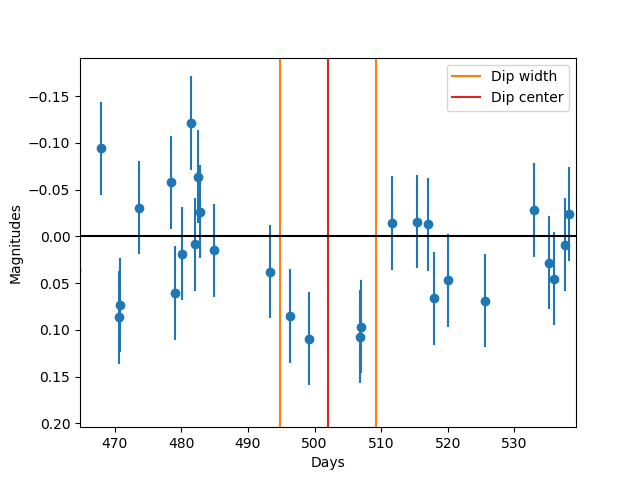

<IPython.core.display.Javascript object>


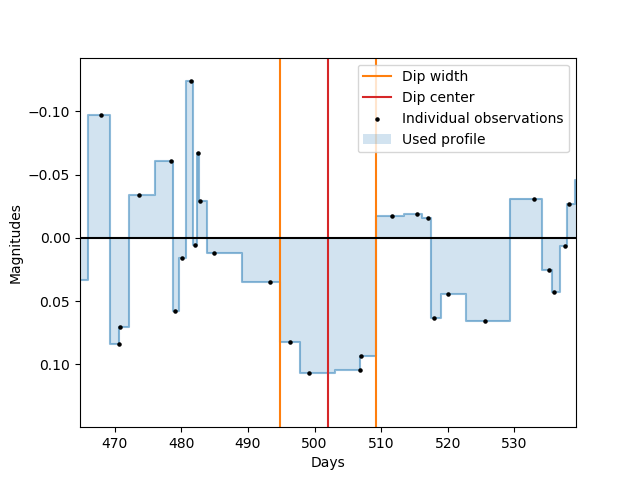

{'integral': 1.4254735027115684,
 'integral_uncertainty': 0.3761895873363201,
 'significance': 3.789242314772445,
 'start_mjd': 494.8213807985526,
 'center_mjd': 502.0234737327513,
 'end_mjd': 509.22556666695004,
 'length': 14.404185868397462,
 'max_gap': 8.380103167928382,
 'max_gap_fraction': 0.5817824932621972,
 'ref_observation_count': 393,
 'ref_pull_std': 0.9575542315901933,
 'ref_large_pull_fraction': 0.27989821882951654,
 'dip_observation_count': 4,
 'significant_observation_count': 4,
 'core_not_significant_fraction': 0.0,
 'significant_width': 10.552146829208311}

In [78]:
# Basic sim
x, y, yerr = simulate_light_curve(400, err=0.05, depth=0.1, width=5)

#x, y, yerr = simulate_light_curve(400, err=0.05)

res = dipper.measure_dip(x, y, yerr)

def annotate_plot():
    plt.axvline(res['start_mjd'], c='C1', label='Dip width')
    plt.axvline(res['center_mjd'], c='C3', label='Dip center')
    plt.axvline(res['end_mjd'], c='C1')
    
    plt.axhline(0, c='k')

    plt.xlim(res['start_mjd'] - 30, res['end_mjd'] + 30)
    plt.gca().invert_yaxis()

    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Magnitudes')

plt.figure(dpi=100)
plt.errorbar(x, y, yerr, fmt='o')
annotate_plot()

res_parsed = dipper.measure_dip(x, y, yerr, return_parsed_observations=True)
if len(res_parsed) > 0:
    mjd = res_parsed['parsed_mjd']
    mag = res_parsed['parsed_mag']
    magerr = res_parsed['parsed_magerr']

    plt.figure(dpi=100)
    plt.scatter(mjd, mag, s=5, c='k', zorder=3, label='Individual observations')
    plt.fill_between(mjd, mag, step='mid', alpha=0.2, label='Used profile')
    plt.plot(mjd, mag, drawstyle='steps-mid', alpha=0.5)
    annotate_plot()

res

<IPython.core.display.Javascript object>


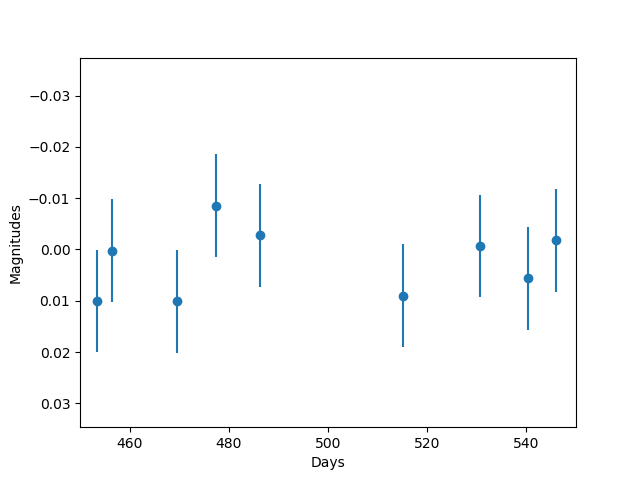

{'integral': 0.19281131247059147, 'integral_uncertainty': 0.08189208143755336, 'significance': 2.3544561218366313, 'start_mjd': 259.1585368226282, 'center_mjd': 264.6273817324025, 'end_mjd': 270.0962266421768, 'length': 10.93768981954861, 'max_gap': 15.972570876870975, 'max_gap_fraction': 1.4603239934930017, 'ref_observation_count': 96, 'ref_pull_std': 1.021487685154745, 'ref_large_pull_fraction': 0.34375, 'dip_observation_count': 2, 'significant_observation_count': 2, 'core_not_significant_fraction': 0.0, 'significant_width': 5.748439540311438}


<IPython.core.display.Javascript object>


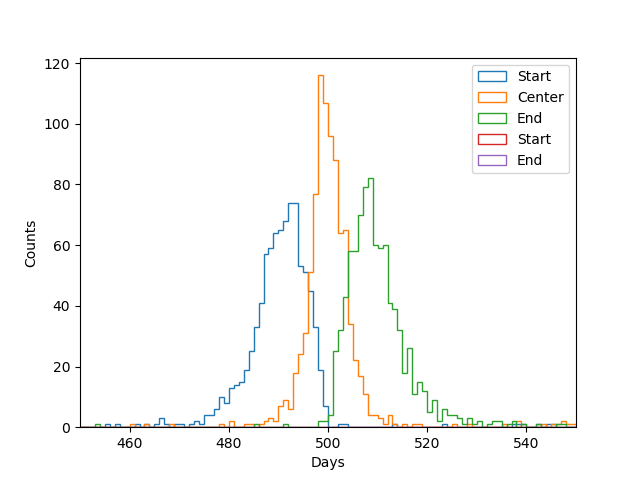

2.3002712666787954


In [81]:
# Simulate a lot of poorly sampled dips, and see how well we recover them.

all_start = []
all_start_2 = []
all_center = []
all_end = []
all_end_2 = []
all_integral = []

for i in range(1000):
    # Basic sim
    x, y, yerr = simulate_light_curve(N=100)
    
    res = dipper.measure_dip(x, y, yerr)
    #start, end = measure_dip(x, y, yerr)
    
    if i == 0:
        # Show the first light curve
        plt.figure(dpi=100)
        plt.errorbar(x, y, yerr, fmt='o')
        plt.gca().invert_yaxis()
        plt.xlim(450, 550)
        plt.xlabel('Days')
        plt.ylabel('Magnitudes')
        print(res)
        
    all_start_2.append(start)
    all_end_2.append(end)
    #all_center.append(0)
    #all_integral.append(0)

    all_start.append(res['start_mjd'])
    all_center.append(res['center_mjd'])
    all_end.append(res['end_mjd'])
    all_integral.append(res['integral'])
    
plt.figure(dpi=100)
plt.hist(all_start, 100, (450, 550), histtype='step', label='Start')
plt.hist(all_center, 100, (450, 550), histtype='step', label='Center')
plt.hist(all_end, 100, (450, 550), histtype='step', label='End')
plt.hist(all_start_2, 100, (450, 550), histtype='step', label='Start')
plt.hist(all_end_2, 100, (450, 550), histtype='step', label='End')
plt.xlim(450, 550)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.legend()
print(np.mean(all_integral))

# Select a random subset of light curves

In [10]:
%%time

# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

# Number of light curves to target
N = 100000

base_sample = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
)

count = base_sample.count()
frac = N / count

# Run the dip detection query on the full ZTF dataset on spark
result = (
    base_sample
    .sample(False, frac)
    .select(
        ztf['mjd_g'],
        ztf['mag_g'],
        ztf['magerr_g'],
        ztf['mjd_r'],
        ztf['mag_r'],
        ztf['magerr_r'],
        ztf['mjd_i'],
        ztf['mag_i'],
        ztf['magerr_i'],
    )
    .write.mode('overwrite').parquet('./sample_lightcurves.parquet')
)

Py4JJavaError: An error occurred while calling o93.listTables.
: java.lang.Exception: Configuration error: connection not available.
	at org.dirac.axs.util.CatalogUtils.getConnection(CatalogUtils.java:49)
	at org.dirac.axs.util.CatalogUtils.listTables(CatalogUtils.java:163)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [87]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

# Number of light curves to target
N = 100000

base_sample = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
)

count = base_sample.count()
frac = N / count

In [88]:
print(count)

775378030


## Tests for debugging

In [17]:
import pandas as pd

In [18]:
df = pd.read_parquet('./sample_lightcurves.parquet')

In [45]:
def count_band(mag, magerr):
    if len(mag) < 10:
        return 0

    mag = np.array(mag)
    magerr = np.array(magerr)

    sub_mag = mag - np.median(mag)
    count = np.sum(sub_mag / magerr > 3.)

    return count

def count_three_sigma(mag_g, magerr_g, mag_r, magerr_r, mag_i, magerr_i):
    count_g = count_band(mag_g, magerr_g)
    count_r = count_band(mag_r, magerr_r)
    count_i = count_band(mag_i, magerr_i)
    
    return int(count_g + count_r + count_i)

import pyspark.sql.types as stypes
udf = sparkfunc.udf(count_three_sigma, stypes.IntegerType())

In [46]:
r = df.iloc[0]
count_three_sigma(r['mag_g'], r['magerr_g'], r['mjd_r'], r['magerr_r'], r['mag_i'], r['magerr_i'])

5

<IPython.core.display.Javascript object>


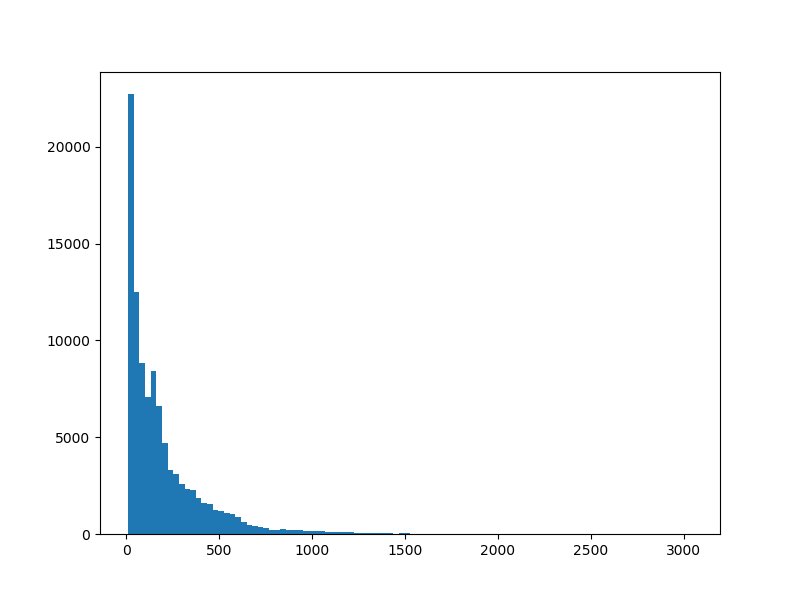

127.0


In [47]:
plt.figure(figsize=(8, 6), dpi=100)
count_g = np.array([len(i) for i in df['mjd_g']])
count_r = np.array([len(i) for i in df['mjd_r']])
count_i = np.array([len(i) for i in df['mjd_i']])
count = count_g + count_r + count_i

plt.hist(count, 100)
print(np.median(count))

In [48]:
sample_wtf = spark_session.read.parquet('./sample_lightcurves.parquet')

In [49]:
result = (
    sample_wtf
    .select(
        '*',d
        udf(
            sample_wtf['mag_g'],
            sample_wtf['magerr_g'],
            sample_wtf['mag_r'],
            sample_wtf['magerr_r'],
            sample_wtf['mag_i'],
            sample_wtf['magerr_i'],
        ).alias('sigcount'),
    )
).collect()

In [18]:
counts = [i['sigcount'] for i in result]

In [44]:
np.sum(np.array(counts) >= 3) / len(counts)

NameError: name 'counts' is not defined

In [42]:
len(lc['mag_r']) * 0.003

0.096

0


<IPython.core.display.Javascript object>


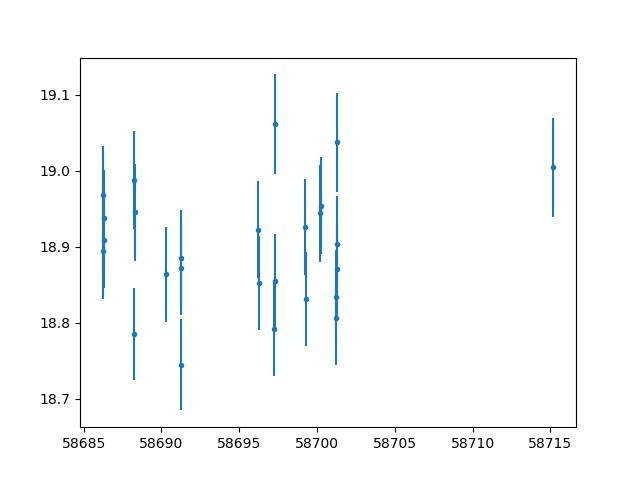

<ErrorbarContainer object of 3 artists>

In [45]:
lc = result[11]
print(lc['sigcount'])
plt.figure()
plt.errorbar(lc['mjd_r'], lc['mag_r'], lc['magerr_r'], fmt='.')

In [24]:
counts

[0,
 0,
 23,
 0,
 0,
 5,
 8,
 0,
 15,
 0,
 0,
 0,
 48,
 13,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 7,
 0,
 0,
 0,
 3,
 0,
 2,
 19,
 54,
 22,
 0,
 106,
 0,
 0,
 0,
 17,
 0,
 0,
 9,
 0,
 0,
 4,
 5,
 8,
 1,
 1,
 13,
 1,
 32,
 0,
 4,
 2,
 0,
 22,
 0,
 0,
 32,
 11,
 8,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 10,
 3,
 6,
 4,
 1,
 3,
 0,
 6,
 0,
 0,
 12,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 12,
 0,
 0,
 7,
 0,
 1,
 14,
 31,
 0,
 16,
 0,
 1,
 34,
 0,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 10,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 2,
 48,
 0,
 1,
 2,
 0,
 0,
 3,
 4,
 5,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 0,
 0,
 0,
 11,
 0,
 0,
 1,
 0,
 1,
 0,
 55,
 3,
 2,
 0,
 0,
 4,
 6,
 0,
 1,
 0,
 0,
 10,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 7,
 0,
 5,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 3,
 2,
 0,
 5,
 0,
 0,
 0,
 1,
 0,
 0,
 5,
 1,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 0,
 5,
 0,
 4,
 0,
 0,
 0,
 10,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 5,
 0,
 9,

<IPython.core.display.Javascript object>


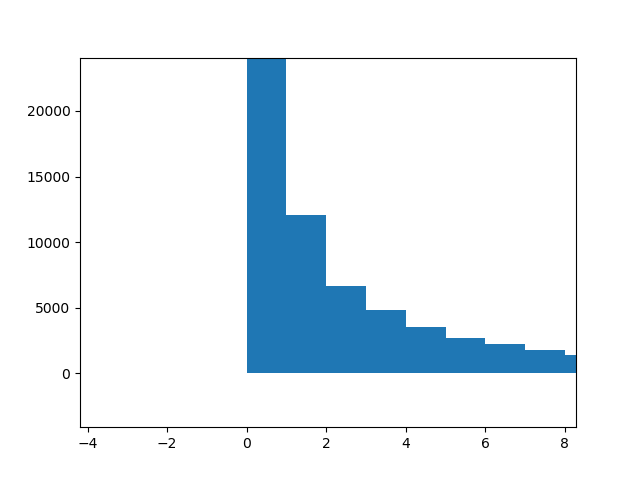

(array([5.4246e+04, 1.2099e+04, 6.6610e+03, 4.8070e+03, 3.5690e+03,
        2.7200e+03, 2.2010e+03, 1.7610e+03, 1.3980e+03, 1.1420e+03,
        9.1800e+02, 8.2200e+02, 7.4400e+02, 6.2000e+02, 4.9100e+02,
        4.3000e+02, 3.9500e+02, 3.6600e+02, 3.0800e+02, 3.0400e+02,
        2.3700e+02, 2.3100e+02, 2.0300e+02, 1.8100e+02, 1.6800e+02,
        1.5000e+02, 1.5300e+02, 1.3200e+02, 1.2600e+02, 1.1500e+02,
        1.0800e+02, 1.1300e+02, 9.7000e+01, 1.0500e+02, 7.3000e+01,
        7.6000e+01, 5.9000e+01, 8.1000e+01, 7.5000e+01, 6.8000e+01,
        6.3000e+01, 5.6000e+01, 4.9000e+01, 5.2000e+01, 5.8000e+01,
        4.4000e+01, 5.4000e+01, 5.5000e+01, 5.2000e+01, 3.8000e+01,
        3.2000e+01, 3.0000e+01, 3.8000e+01, 3.3000e+01, 2.8000e+01,
        3.5000e+01, 3.2000e+01, 2.1000e+01, 2.4000e+01, 3.0000e+01,
        2.0000e+01, 3.1000e+01, 2.1000e+01, 2.1000e+01, 1.8000e+01,
        2.4000e+01, 1.4000e+01, 1.8000e+01, 2.6000e+01, 1.5000e+01,
        1.5000e+01, 2.1000e+01, 1.7000e+01, 1.40

In [20]:
plt.figure()
plt.hist(counts, 100, (0, 100))

In [85]:
parquet_wtf.count()

100139

In [209]:
ztf = catalog.load('ztf_oct19')

In [233]:
wtf = catalog.load('wtf_full_oct19_6')

In [234]:
rows = wtf.head(100000)

In [210]:
rows = ztf.head(100000)

In [235]:
import importlib
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [236]:
%%time

result = []

for row in rows:
    result.append(dipper.measure_dip_row(row, apply_cuts=True, min_significance=5.))

CPU times: user 1min 24s, sys: 0 ns, total: 1min 24s
Wall time: 1min 24s


In [237]:
import pandas as pd
result = pd.DataFrame(result)

In [276]:
o = np.argsort(np.array(result['significance']))
print(o[~np.isnan(result['significance'][o])][-100:])

[23978 83211 28499  9256 21169 67678 84996 22066 67939 41255 10943 66222
 12224 12223 16789 44090 67198  1092 23586 85411 40401 50297 44902 20179
 77824 25984  8055 58124  4518 79336 51693 44097 76708  9328 80843 17569
 63974 65644 63944 67644 35037 75566 25348 58260 73083 25349 74535   428
 24344 77825 87156 44092 54348 44093 13771 46470 52928 51371 63679 40522
 44094 13498  7962 69834 70233 40561 53472 69501 55916 44099 74171  3800
 66345 14680 21316  8577 64279 81188 69832 76097 47383 77817 77819 10942
 24416 86714 13386 21464 74166 50731 75977  3799 54393 39181 21234 28840
 64224 74835 80480 22435]


In [240]:
good_locs = np.where(
    (result['significance'] > 5)
    #(result['significant_length'] > 0.5)
    #& (result['max_gap_fraction'] < 0.5)
    #& (result['ref_pull_std'] < 2)
)[0]
print(good_locs)

[    7    10    21 ... 88083 88084 88090]


In [241]:
len(good_locs)

32341

In [220]:
len(good_locs) / 100000 * 800000000

456000.0

In [135]:
%matplotlib notebook

RA+Dec: 76.541824+39.684195

Dip details:
integral   : 1.8860200643539429
integral_uncertainty: 0.08533726632595062
significance: 22.100778579711914
start_mjd  : 58345.72265625
center_mjd : 58350.3984375
end_mjd    : 58361.28515625
length     : 15.562779426574707
max_gap    : 2.0335185527801514
window_start_mjd: 58333.9765625
observation_count: 28
significant_observation_count: 12
ref_pull_std: 1.500573754310608
ref_large_pull_fraction: 0.0628272220492363


<IPython.core.display.Javascript object>


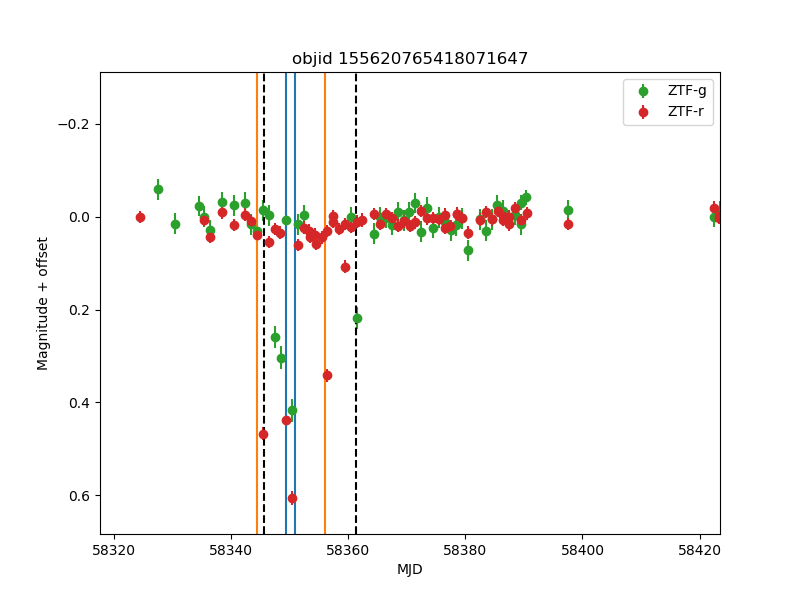

start_mjd                        58349.466615
end_mjd                          58350.981458
core_significance                   44.158828
window_start_mjd                 58344.466615
window_end_mjd                   58355.981458
significant_observation_count       11.000000
significant_length                  10.018438
integral                             1.517704
integral_uncertainty                 0.044703
significance                        33.951166
max_gap                              0.998947
max_gap_fraction                     0.086753
ref_observation_count              219.000000
ref_pull_std                         2.324935
ref_large_pull_fraction              0.068493
Name: 66222, dtype: float64


In [280]:
#idx = good_locs[0]
idx = 66222

dipper.plot_light_curve(rows[idx])
z = result.iloc[idx]
plt.axvline(z['start_mjd'])
plt.axvline(z['end_mjd'])
plt.axvline(z['window_start_mjd'], c='C1')
plt.axvline(z['window_end_mjd'], c='C1')
#plt.xlim(z['window_start_mjd'], z['window_end_mjd'])
#plt.xlim(z['window_start_mjd'], z['window_end_mjd'])

print(z)

In [270]:
ff = dipper.measure_dip_row(rows[idx], return_parsed_observations=True)

In [217]:
from scipy.signal import convolve

In [222]:
x = np.arange(1000)

In [223]:
%%timeit

convolve(x, np.ones(3), mode='same')

23.9 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [224]:
%%timeit

x + np.roll(x, 1) + np.roll(x, -1)

21.1 µs ± 81.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [129]:
8 / 10000

0.0008

<IPython.core.display.Javascript object>


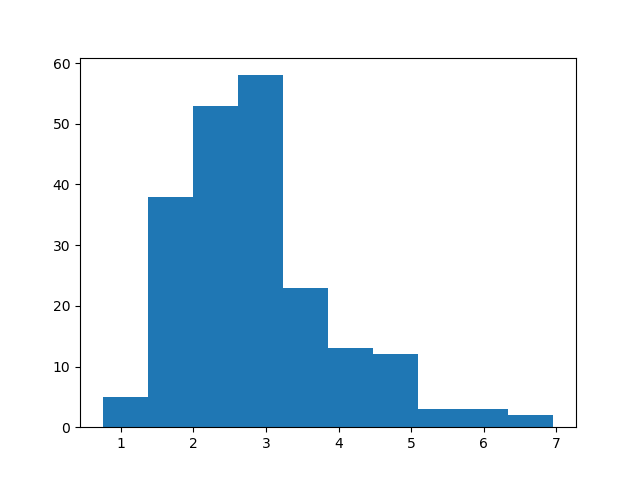

/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/epyc/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 5., 38., 53., 58., 23., 13., 12.,  3.,  3.,  2.]),
 array([0.75065447, 1.37158451, 1.99251455, 2.61344459, 3.23437463,
        3.85530468, 4.47623472, 5.09716476, 5.7180948 , 6.33902484,
        6.95995489]),
 <a list of 10 Patch objects>)

In [120]:
plt.figure()
plt.hist(result['significance'])
#pd.DataFrame(result)